<a href="https://colab.research.google.com/github/Shashank-Ojha/WordFormer/blob/main/trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch
!pip install torchvision
%load_ext autoreload
%autoreload 2

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: /usr/local/opt/python/bin/python3.7 -m pip install --upgrade pip
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config fil

In [173]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from torch.utils.data.sampler import SubsetRandomSampler  #for validation test

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets, transforms

from utils.diffusion_model import DiffusionConfig
from utils.diffusion_model import DiffusionModel

from utils.diffusion_model import UNet



# Set a seed for reproducibility
torch.manual_seed(0)

In [174]:
# Define a transform to convert to images to tensor and normalize

transform = transforms.Compose([
    # Resize the input image so that the height and width are powers of 2.
    # This makes it easy for the UNET which divides/multiplies the height
    # width by 2 each step.
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
    # Mean and std have to be sequences (e.g. tuples). You are supposed
    # to provide the mean and std for each channel, but in our case we just
    # have 1 channel.
    # This normalizes the data such that:
    # --  output[channel] = (input[channel] - mean[channel]) / std[channel]
    transforms.Normalize((0.5,),(0.5,),) # Standardize assuming mean,var = 0.5
]) 


# 
dataset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=transform)
image, label = dataset[0]

print(f"Size of dataset: {len(dataset)}")
print(f"Image Shape: {image.shape}")
print(f"Label: {label}")

labels = torch.tensor(dataset.targets)
unique_labels = torch.unique(labels)
print("Unique labels:", unique_labels)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

Size of dataset: 10000
Image Shape: torch.Size([1, 32, 32])
Label: 9
Unique labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [201]:
# ------ Hyperparameters ------

# -- Data Breakdown
batch_size = 128

# -- Model Parameters
start_schedule = 0.001
end_schedule = 0.02
time_steps = 300

# -- Training Parameters
learning_rate = 0.0001
max_iters = 2000
eval_iters = 50

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [186]:
# Let's break down the data into batches.
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Now we should have the data in batch sizes of 64
for images, labels in dataloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([8, 1, 32, 32])
torch.Size([8])


In [187]:
# We can repeatedly call this infintely to get a new batch
images, labels = next(iter(dataloader))

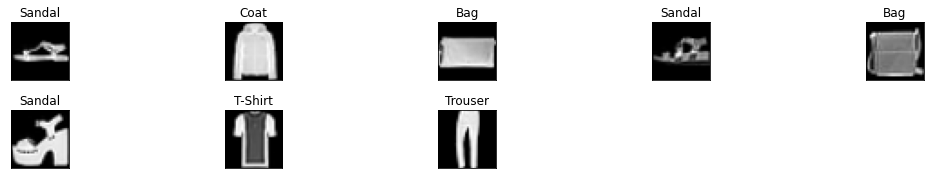

In [189]:
fig = plt.figure(figsize=(15,5))
for idx in np.arange(min(batch_size, 20)):
  # xticks=[], yticks=[] is empty to print the images without any ticks around them
  #np.sqeeze : Remove single-dimensional entries from the shape of an array.
  ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
   # .item() gets the value contained in a Tensor
  ax.set_title(labels_map[labels[idx].item()])
  fig.tight_layout()

In [202]:
# -- Define Network
config_dict = {
    'start_schedule': start_schedule,
    'end_schedule': end_schedule,
    'time_steps': time_steps,
}

config = DiffusionConfig(**config_dict)
print(config)

model = DiffusionModel(config)
unet = UNet()

model = model.to(device)
unet = unet.to(device)

DiffusionConfig(start_schedule=0.001, end_schedule=0.02, time_steps=300)


torch.Size([8, 1, 32, 32])
tensor([  0,  42,  85, 128, 170, 213, 256, 299])


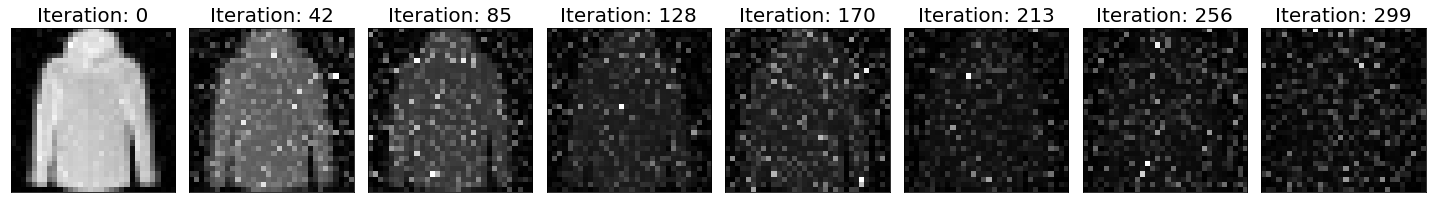

In [203]:
images, labels = next(iter(dataloader))

# Specify the number of images you want to display.
NUM_DISPLAY_IMAGES = 8

image = images[0]
image_stack = torch.stack([image] * NUM_DISPLAY_IMAGES)

print(image_stack.shape)
t = torch.linspace(0, time_steps-1, NUM_DISPLAY_IMAGES).long()
print(t)

noisy_image_series, _ = model.destroy(image_stack, t)

fig = plt.figure(figsize=(20, 5))
for idx, image in enumerate(noisy_image_series):
  ax = fig.add_subplot(1, NUM_DISPLAY_IMAGES, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(image), cmap='gray')
  ax.set_title(f"Iteration: {t[idx].item()}", fontsize=20)
  fig.tight_layout()

In [205]:
# -- Training

# Create a PyTorch optimizer
optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)

images, labels = next(iter(dataloader))
images = images.to(device)

# Training Loop
for i in range(max_iters):
    # Shape = (batch_size, block_size)
#     images, labels = next(iter(dataloader))
#     images, labels = images.to(device), labels.to(device)
    mean_epoch_loss = []
    
    batch = torch.stack([images[0]] * batch_size)
    
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Sample timesteps
    t = torch.randint(0, time_steps, (batch_size,)).long().to(device)
    
    # Detroy samples.
    # Shapes are (batch_size, num_channels, height, width) for both
    noisy_images, noise = model.destroy(batch, t)
    
    # Shape = (batch_size, num_channels, height, width)
    predicted_noise = unet(noisy_images, t)
    
    # Compute loss
    loss = torch.nn.functional.mse_loss(predicted_noise, noise)
    mean_epoch_loss.append(loss.item())
    loss.backward()

    # Adjust weights
    optimizer.step()
    
    # Gather data report
    if i % eval_iters == 0 or i == max_iters - 1:
        print(f"step {i}: train loss {np.mean(mean_epoch_loss):.4f}")
        

step 0: train loss 1.0417


KeyboardInterrupt: 